In [1]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.primitives import StatevectorEstimator

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 100
dmrg_mps_bond = 10
adapt_mps_bond = 10
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[211]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000012)]
Operator(s) added to ansatz: [211]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-3.4142135623691776)]
Operator(s) added to ansatz: [244]
Initial energy: -3.828427124746197
Optimizing energy with indices [211, 244]...
Starting point: [np.float64(-0.3926990817001106), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474288453)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926734934)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 210]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134318
(change of -0.1368254603146104)
Current ansatz: [241, 79, 228, 198, 210]
Performing final convergence check...
Total gradient norm: 2.9260899740755612e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

I

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.99999999947531
(change of -1.3737154598403372)
Current ansatz: [199, 228, 74]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958972842288
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000010469514)]
Operator(s) added to ansatz: [210]
Initial energy: -5.99999999947531
Optimizing energy with indices [199, 228, 74, 210]...
Starting point: [np.float64(3.9073961917877325e-07), np.float64(-0.785409698652679), np.float64(-0.7854095118369314), np.float64(0.0)]

Current energy: -6.123105625542284
(change of -0.12310562606697406)
Current ansatz: [199, 228, 74, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752481649
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850702765206796)]
Operator(s) added to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154710374
(change of -0.2041705291680893)
Current ansatz: [199, 228, 74, 210, 225]
Performing final convergence check...
Total gradient norm: 6.240960102324599

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.91752481649 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[211]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000012)]
Operator(s) added to ansatz: [211]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999475319
(change of -1.3737154598403487)
Current ansatz: [211, 225, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958972842302
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999973729334)]
Operator(s) added to ansatz: [228]
Initial energy: -5.999999999475319
Optimizing energy with indices [211, 225, 79, 228]...
Starting point: [np.float64(-3.9073961363620977e-07), np.float64(0.7854096986526952), np.float64(0.7854095118369462), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625446782
(change of -0.1231056259714629)
Current ansatz: [211, 225, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917548366257474
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850834011249905)]
Operator(s) added to ansatz: [135]
Initial energy: -6.123105625446782
Optimizing energy with indices [211, 225, 79, 228, 135]...
Starting point: [np.float64(-2.6259805267926943e-06), np.float64(0.7854001390902021), np.float64(0.785395798307944), np.float64(0.12249246283513109), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154802396
(change of -0.20417052935561397)
Current ansatz: [211, 225, 79, 228, 135]
Performing final convergence check...
Total gradient norm: 6.2409631751033094

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917548366257474 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.8533386

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000018)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047430588)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580530028
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926737891)]
Operator(s) added t

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000004)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710477671423)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775814
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710484682814)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 210]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224892796166995), np.float64(0.0)]

Current energy: -6.327276154765011
(change of -0.20417052920252932)
Current ansatz: [228, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069117
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491643863324)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154765011
Optimizing energy with indices [228, 79, 228, 210, 198]...
Starting point: [np.float64(-0.78539470657713), np.float64(0.7853982468601272), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614726
(change of -1.49682108597976)
Current ansatz: [210, 244, 74]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91753072094677
Operators under consideration (1):
[201]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850735674454114)]
Operator(s) added to ansatz: [201]
Initial energy: -6.123105625614726
Optimizing energy with indices [210, 244, 74, 201]...
Starting point: [np.float64(0.12248992873680824), np.float64(0.785398145589034), np.float64(-0.7853981585308706), np.float64(0.0)]

Current energy: -6.327276154819991
(change of -0.2041705292052649)
Current ansatz: [210, 244, 74, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963987160017
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916918532602)]
Operator(s) added to a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428078)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916447538887)]
Operator(s) added to ansatz: [147]
Initial energy: -6.32727615481998
Optimizing energy with indices [244, 26, 228, 210, 147]...
Starting point: [np.float64(0.785398156811469), np.float64(0.785398154431449), np.float64(0.16357028642350993), np.float64(0.16356997171157828), np.float64(0.0)]

Current energy: -6.464101615058578
(change of -0.13682546023859743)
Current ansatz: [244, 26, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.0001435936123970028

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initia

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620076776
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710481679252)]
Operator(s) added to ansatz: [228]
Initial energy: -6.123105625617633
Optimizing energy with indices [244, 26, 201, 228]...
Starting point: [np.float64(0.7853981623804095), np.float64(0.7853981628011234), np.float64(0.12248927953377206), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819943
(change of -0.20417052920230994)
Current ansatz: [244, 26, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964119013302
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894915756965067)]
Operator(s) added to ansatz: [216]
Initial energy: -6.327276154819943
Optimizing energy with indices [244, 26, 201, 228, 216]...
Starting point: [np.float64(0.7853982147172043), np.float64(0.7853982023026392), np.float64(0.16357029121900768), np.float64(0.16356998975892215), np.float64(0.0)]

Current energy: -6.46410161478899
(change of -0.13682545996904683)
Current ansatz: [244, 26, 201, 228, 216]
Performing final convergence check...
Total gradient norm: 0.00026970019331516135

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964119013302 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000004)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047767087)]
Operator(s) added to ansatz: [135]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013504800204974552

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964036853147 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[74]
Corresponding gradients (ordered by magnitude):
[np.float64(4.000000000000007)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710477670868)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916426871495)]
Operator(s) added to ansatz: [198]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 198]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.f

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047429203)]
Operator(s) added to ansatz: [198]
Initial energy: -6.12310562561763

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140567
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000024785)]
Operator(s) added to ansatz: [210]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 210]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625156506
(change of -0.12310562515832135)
Current ansatz: [228, 74, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917524647985756
Operators under consideration (1):
[180]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850701803347293)]
Operator(s) added to ansatz: [180]
Initial energy: -6.1231056251

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154570217
(change of -0.2041705294137115)
Current ansatz: [228, 74, 210, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240942647928968
Operators under consideration (1):
[57]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0895108433634917)]
Operator(s) added to ansatz: [57]
Initial energy: -6.327276154570217
Optimizing energy with indices [228, 74, 210, 180, 57]...
Starting point: [np.float64(-0.7853992293019694), np.float64(-0.785402661890199), np.float64(0.16356498385341114), np.float64(-0.16356905917020215), np.float64(0.0)]

Current energy: -6.4641016145392625
(change of -0.13682545996904505)
Current ansatz: [228, 74, 210, 180, 57]
Performing final convergence check...
Total gradient norm: 0.0003771958284582009

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240942647928968 > 1e-05)

Init

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.424922649146182e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531976 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operators under consideration (1):
[244]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000005)]
Operator(s) added to ansatz: [244]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-4.000000000000007)]
Operator(s) add

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.000000000000001)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047429203)]
Operator(s) added to ansatz: [210]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916434588646)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz: [244, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047429203)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916434588646)]
Operator(s) added to ansatz: [198]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz: [244, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operators under consideration (1):
[198]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710477670868)]
Operator(s) added to ansatz: [198]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 198]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819701
(change of -0.20417052920205414)
Current ansatz: [244, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531868
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0894929267348714)]
Operator(s) added to ansatz: [210]
Initial energy: -6.327276154819701
Optimizing energy with indices [244, 74, 228, 198, 210]...
Starting point: [np.float64(0.7853981767050704), np.float64(-0.7853981525341414), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000004)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710477670868)]
Operator(s) added to ansatz: [147]
Initial energy: -6.1231056256176

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operators under consideration (1):
[216]
Corresponding gradients (ordered by magnitude):
[np.float64(2.000000000000005)]
Operator(s) added to ansatz: [216]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 216]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.1231056256176455
(change of -0.1231056256176366)
Current ansatz: [244, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200768382
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071048168266)]
Operator(s) added to ansatz: [225]
Initial energy: -6.123105625617645

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.485071047428929)]
Operator(s) added to ansatz: [147]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 147]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.12248927934333585), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [241, 31, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531371
Operators under consideration (1):
[45]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926735604)]
Operator(s) added to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.4850710474292024)]
Operator(s) added to ansatz: [147]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.089492926734874)]
Operator(s) added to ansatz: [135]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 135]...
Starting point: [np.float64(0.7853981646904773), np.float64(0.7853981643651435), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140567
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(1.99999999999442)]
Operator(s) added to ansatz: [225]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 225]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625610642
(change of -0.12310562561245764)
Current ansatz: [228, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955728
Operators under consideration (1):
[45]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850687898620123)]
Operator(s) added to ansatz: [45]
Initial energy: -6.12310562561064

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548148635
(change of -0.2041705292042213)
Current ansatz: [228, 74, 225, 45]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962434866086
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089493170109074)]
Operator(s) added to ansatz: [147]
Initial energy: -6.3272761548148635
Optimizing energy with indices [228, 74, 225, 45, 147]...
Starting point: [np.float64(-0.7853982948161984), np.float64(-0.7853991637531028), np.float64(-0.1635702103545667), np.float64(0.16356958140448882), np.float64(0.0)]

Current energy: -6.4641016144641945
(change of -0.13682545964933102)
Current ansatz: [228, 74, 225, 45, 147]
Performing final convergence check...
Total gradient norm: 0.0003452448185512616

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962434866086 > 1e-05)

In

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047429297)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 210]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020577)
Current ansatz: [241, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531791
Operators under consideration (1):
[57]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089492926734878)]
Operator(s) added to ansatz: [57]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 79, 225, 210, 57]...
Starting point: [np.float64(-0.7853981607743267), np.float64(0.7853981678304174), np.float64(-0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775818
Operators under consideration (1):
[135]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710484682823)]
Operator(s) added to ansatz: [135]
Initial energy: -6.1231056255624825
Optimizing energy with indices [228, 26, 228, 135]...
Starting point: [np.float64(-0.7853947065772612), np.float64(0.7853985308794263), np.float64(0.12248927961669973), np.float64(0.0)]

Current energy: -6.327276154765009
(change of -0.20417052920252665)
Current ansatz: [228, 26, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069115
Operators under consideration (1):
[147]
Corresponding gradients (ordered by magnitude):
[np.float64(2.089491643863325)]
Operator(s) added to ansatz: [147]
Initial energy: -6.327276154765009
Optimizing energy with indices [228, 26, 228, 135, 147]...
Starting point: [np.float64(-0.7853947065771235), np.float64(0.7853982468601091), np.fl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operators under consideration (1):
[225]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0000000000000004)]
Operator(s) added to ansatz: [225]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operators under consideration (1):
[45]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047767142)]
Operator(s) added to ansatz: [45]
Initial energy: -6.123105625617647

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999999944214)]
Operator(s) added to ansatz: [228]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 228]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610647
(change of -0.12310562561245852)
Current ansatz: [225, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955765
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850687898689605)]
Operator(s) added to ansatz: [210]
Initial energy: -6.12310562561

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.0000000000000018)]
Operator(s) added to ansatz: [228]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.485071047428078)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964040371926
Operators under consideration (1):
[57]
Corresponding gradients (ordered by magnitude):
[np.float64(2.0894916447538883)]
Operator(s) added to 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -4.626284539634971
(change of -0.7978574148887749)
Current ansatz: [198, 244]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 12.267802768730808
Operators under consideration (1):
[79]
Corresponding gradients (ordered by magnitude):
[np.float64(-3.7252880369998884)]
Operator(s) added to ansatz: [79]
Initial energy: -4.626284539634971
Optimizing energy with indices [198, 244, 79]...
Starting point: [np.float64(-0.2651612229607243), np.float64(0.4454690709399146), np.float64(0.0)]

Current energy: -5.99999999941725
(change of -1.3737154597822787)
Current ansatz: [198, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.79795897018112
Operators under consideration (1):
[228]
Corresponding gradients (ordered by magnitude):
[np.float64(-1.9999999998057545)]
Operator(s) added to ansatz: [228]
Initial energy: -5.99999999941725
Optimizing energy with indices [198, 244, 79, 228]...
Starting point: [np.float64(-9.855305244099077e-06), np.float64(0.7853981714334953), np.float64(0.7853981407343851), np.float64(0.0)]

Current energy: -6.123105625041502
(change of -0.12310562562425176)
Current ansatz: [198, 244, 79, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200501854
Operators under consideration (1):
[210]
Corresponding gradients (ordered by magnitude):
[np.float64(-2.4850710482493277)]
Operator(s) added to ansatz: [210]
Initial energy: -6.123105625041502
Optimizing energy with indices [198, 244, 79, 228, 210]...
Starting point: [np.float64(-9.693230674187634e-06), np.float64(0.7853983074098867), np.float64(0.7853977639852979), np.float64(0.12248927961503825), np.float64(0.0)]

Current energy: -6.3272761542714075
(change of -0.20417052922990564)
Current ansatz: [198, 244, 79, 228, 210]
Performing final convergence check...
Total gradient norm: 6.240962748728147

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917526200501854 > 1e-05)
Pool will be tiled from 22 ops


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [5]:
# Now go to the larger size.
new_l = 4 * l
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(10):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    ansatz_circuit = pool.get_circuit(tn_adapt.indices, tn_adapt.coefficients)
    print("coefficients:", tn_adapt.coefficients)
    print("indices:", tn_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(nq)
    circuit = QuantumCircuit(q)
    ref_circuit = neel_circuit(nq, start_zero=False)
    circuit = circuit.compose(ref_circuit)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

Got DMRG energy -2.76469e+01
Tiled pool has 202 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -14.999999999999936
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000002
Operator 1: -3.9999999999999853
Operator 2: 3.9999999999999782
Operator 3: -3.9999999999999756
Operator 4: 3.9999999999999787
Operator 5: -3.9999999999999822
Operator 6: 4.000000000000005
Operator 7: -3.999999999999995
Operator 8: 3.9999999999999885
Operator 9: -3.999999999999975
Operator 10: 3.999999999999987
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -17.892922
         Iterations: 5
         Function evaluations: 91
         Gradient evaluations: 74

Current energy: -17.89292222699219
(change of -0.8284271247462982)
Current ansatz: [169, 188, 166]
coefficients: [np.float64(0.39269908300107814), np.float64(-0.5535743597228896), np.float64(0.3926990817037882)]
indices: [169, 188, 166]
On iteration 3.

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.8944271880453085
Operator 1: -4.0000000000000195
Operator 2: 4.000000000000002
Operator 3: -3.999999999999999
Operator 4: 4.000000000000003
Operator 5: -3.414213562358778
Operator 7: -3.414213562358788
Operator 8: 3.4142135586894904
Operator 9: 1.4734439446328906e-08
Operator 10: 3.4142135586894873
Operator 11: -4.000000000000004
Operator 12: 4.000000000000011
Operator 13: -4.0000000000000115
Operator 15: -2.8944271880453085
Operator 16: 4.0000000000000195

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -20.063861
         Iterations: 10
         Function evaluations: 137
         Gradient evaluations: 117

Current energy: -20.063860908300356
(change of -0.9348707038084356)
Current ansatz: [169, 188, 166, 173, 164]
coefficients: [np.float64(0.3926990830903995), np.float64(-0.5535743583032001), np.float64(0.4431436457312779), np.float64(0.5535743586508042), np.float64(0.4431436457666283)]
indices: [169, 188, 166, 173, 164]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.894427193124545
Operator 1: -4.000000000000014
Operator 2: 3.9999999999999964
Operator 3: -3.2645854456701144
Operator 5: -2.5291708914497812
Operator 7: -3.264585445779672
Operator 8: 3.414213558436847
Operator 9: 1.574498295081312e-08
Operator 10: 3.4142135584368436
Operator 11: -3.9999999999999964
Operator 12: 2.894427191880895
Operator 15: -2.894427193124545
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -21.122828
         Iterations: 11
         Function evaluations: 192
         Gradient evaluations: 173

Current energy: -21.122828488982723
(change of -1.058967580682367)
Current ansatz: [169, 188, 166, 173, 164, 94]
coefficients: [np.float64(0.39269908138347626), np.float64(-0.6553685211154132), np.float64(0.4431436460620996), np.float64(0.5535743579285856), np.float64(0.4431436456276534), np.float64(0.5048173547524759)]
indices: [169, 188, 166, 173, 164, 94]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.5786157379103312
Operator 2: 3.064340051012463
Operator 3: -3.2645854461007944
Operator 5: -2.5291708908552684
Operator 7: -3.264585444754493
Operator 8: 3.414213563264762
Operator 10: 3.41421356326476
Operator 11: -4.000000000000008
Operator 12: 2.894427194464789
Operator 14: 3.8486843167314165e-08
Operator 15: -2.2736821054136787

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.375284
         Iterations: 13
         Function evaluations: 53
         Gradient evaluations: 52

Current energy: -22.375284053874815
(change of -1.2524555648920916)
Current ansatz: [169, 188, 166, 173, 164, 94, 134]
coefficients: [np.float64(0.4901254764438521), np.float64(-0.6553685359636564), np.float64(0.44314363106479154), np.float64(0.7010350187592747), np.float64(0.443143661711486), np.float64(0.5048173805966985), np.float64(0.6115719318015798)]
indices: [169, 188, 166, 173, 164, 94, 134]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.5786155929917154
Operator 1: 1.8665872652526026e-07
Operator 2: 3.064339963489719
Operator 3: -3.2645853962583233
Operator 4: -1.9983633825512492e-07
Operator 5: -2.5291708874882275
Operator 6: 1.90204411530141e-07
Operator 7: -3.2645854912299344
Operator 8: 3.11362822703031
Operator 9: 8.105

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [6]:
for circuit in circuits:
    print(circuit.depth())

11
16
25
32
41
48
57
66
73
82


Text(0, 0.5, 'Energy error')

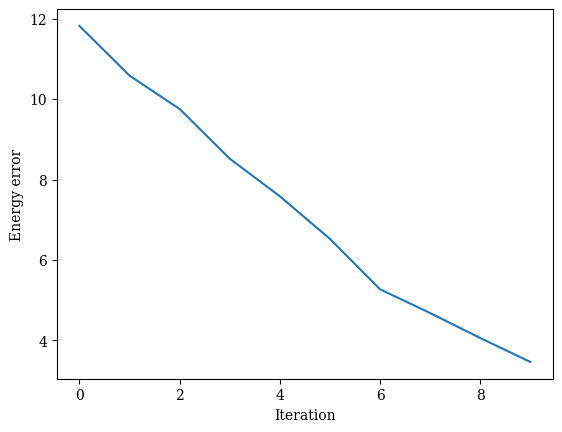

In [7]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [8]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Carry out SQD.

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)


In [10]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'x': 8, 'cx': 6, 'rz': 3, 'sx': 2, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'cx': 14, 'rz': 12, 'sx': 8, 'x': 8, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 24, 'rz': 21, 'measure': 16, 'sx': 12, 'x': 9, 'barrier': 4})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 31, 'rz': 26, 'measure': 16, 'sx': 14, 'x': 9, 'barrier': 5})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 38, 'rz': 36, 'sx': 18, 'measure': 16, 'x': 10, 'barrier': 6})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 45, 'rz': 41, 'sx': 22, 'measure': 16, 'x': 10, 'barrier': 7})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 54, 'cx': 52, 'sx': 28, 'measure': 16, 'x': 11, 'barrier': 8})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 63, 'cx': 58, 'sx': 32, 'measure': 16, 'x': 11, 'barrier': 9})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 71, 'cx': 62, 'sx': 38, 'me

In [11]:
energies = []
errors = []

for bit_array in bit_arrays:
    print(bit_array.num_bits)
    bit_matrix = bit_array.to_bool_array()
    print(bit_matrix.shape)
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)
16
(30000, 16)


Text(0, 0.5, 'Energy error')

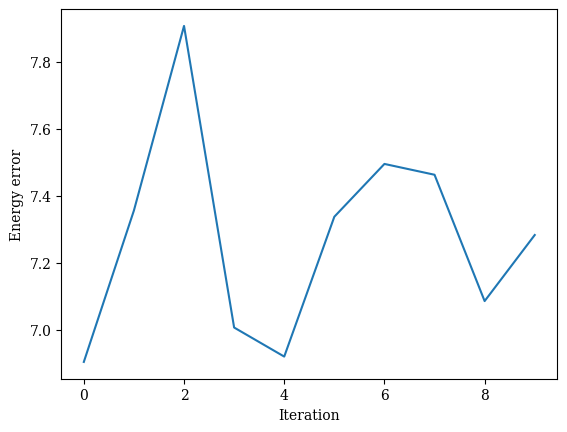

In [12]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [13]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

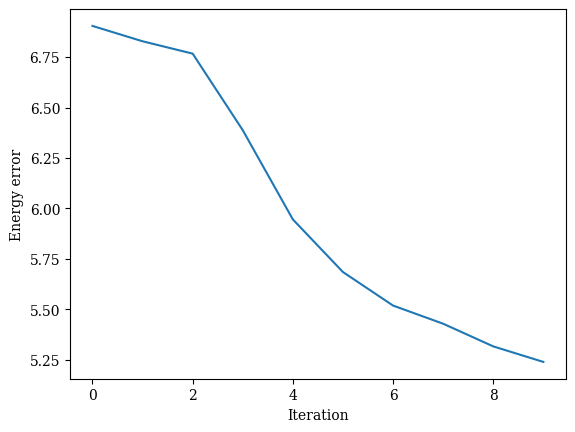

In [14]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

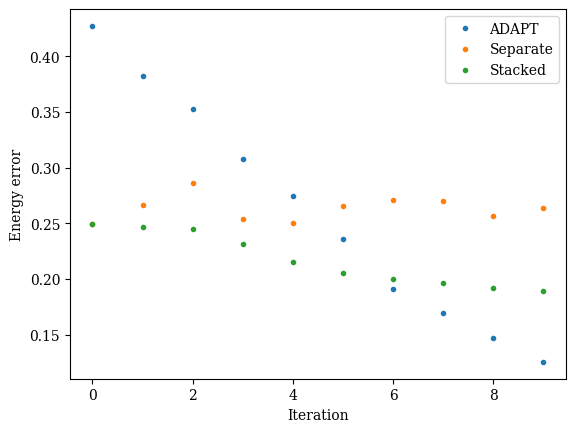

In [15]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="Separate")
ax.plot(stacked_rel_errors, '.', label="Stacked")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()